In [283]:
import torch
import numpy as np
import torch.nn as nn
from torch.autograd import Variable
from modules.stn import STN
from modules.gridgen import CylinderGridGenV2, AffineGridGen, DenseAffine3DGridGen, DenseAffine3DGridGen_rotate, Depth3DGridGen_with_mask, Depth3DGridGen
from PIL import Image
from matplotlib import mlab
import matplotlib.pyplot as plt
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [284]:
cgen = Depth3DGridGen_with_mask(64, 128).cuda()

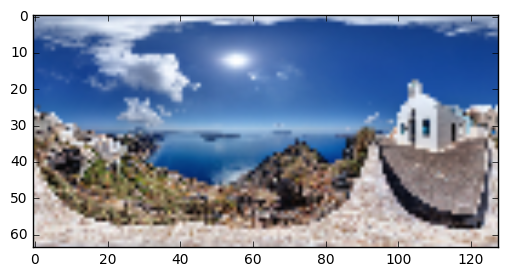

In [285]:
from PIL import ImageFilter
img = Image.open('equi.png').convert('RGB').resize((128,64))
img = np.array(img)/255.0
plt.imshow(img)

In [286]:
input1 = Variable(torch.from_numpy(np.expand_dims(img.astype(np.float32), 0))).repeat(64,1,1,1)

In [287]:
st = STN()

In [288]:
rotate = Variable(torch.from_numpy(np.array([[0.7]]).astype(np.float32))).cuda().repeat(64,1)
trans0 = Variable(torch.from_numpy(np.array([[0.5]]).astype(np.float32))).cuda().repeat(64,1)
trans1 =  Variable(torch.from_numpy(np.array([[0.4]]).astype(np.float32))).cuda().repeat(64,1)

In [289]:
depth = Variable(torch.ones(1,64,128,1), requires_grad = True).cuda().repeat(64,1,1,1)
depth[0,20:40, 20:30,:] = 1.2

In [290]:
time out= cgen(depth, trans0, trans1, rotate)

CPU times: user 232 ms, sys: 12 ms, total: 244 ms
Wall time: 30.7 ms


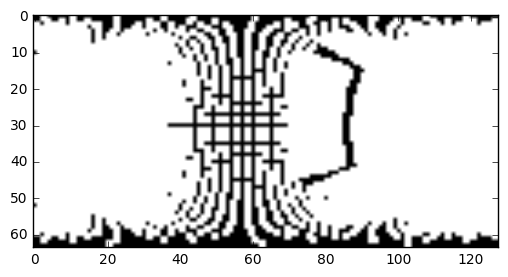

In [291]:
plt.imshow(occu[0,:,:,0], cmap='gray')

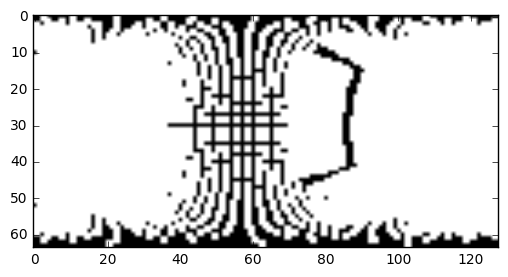

In [266]:
plt.imshow(occu[0,:,:,0], cmap='gray')

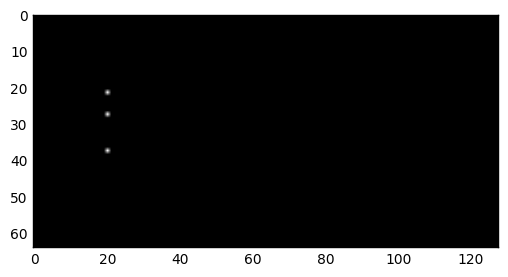

In [253]:
plt.imshow(occu3[0,:,:,0], cmap='gray')

In [254]:
out.size()

torch.Size([64, 64, 128, 2])

In [255]:
out.backward(torch.rand(1,64,128,2).cuda())

RuntimeError: size '[64 x 64 x 128 x 1]' is invalid for input of with 8192 elements at /data/users/soumith/builder/wheel/pytorch-src/torch/lib/TH/THStorage.c:59

In [256]:
time imgout = st(input1, out.cpu())

CPU times: user 200 ms, sys: 0 ns, total: 200 ms
Wall time: 21.3 ms


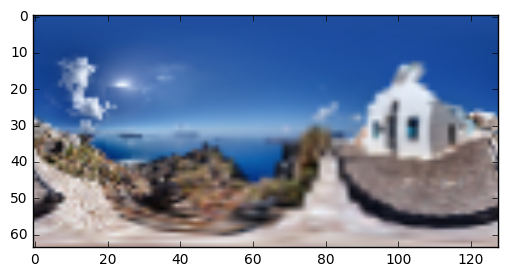

In [257]:
plt.imshow(imgout.data.numpy()[0][:,:,0:3])

In [258]:
img2 = Variable(torch.from_numpy(occu.astype(np.float32)))

In [259]:
imgout = st(img2, out.cpu())

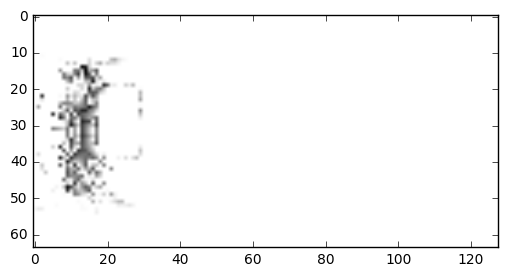

In [260]:
plt.imshow(imgout.data.numpy()[0][:,:,0], cmap = 'gray')

In [248]:
grid_data = out.cpu().data.numpy()[0]

In [249]:
delta = 0.025
x = np.arange(-1, 1, 2/128.0)
y = np.arange(-1, 1, 2/64.0)
X, Y = np.meshgrid(x, y)
Z1 = grid_data[:,:,0]
Z2 = grid_data[:,:,1]

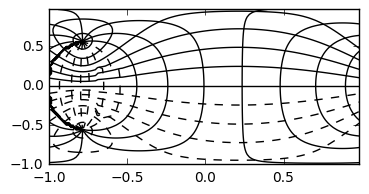

In [269]:
fig = plt.figure(figsize=(4,2))
CS = plt.contour(X, Y, Z1, 15, colors='k')
#plt.clabel(CS, fontsize=9, inline=1)
CS = plt.contour(X, Y, Z2, 15, colors='k')
#plt.clabel(CS, fontsize=9, inline=1)

In [270]:
%load_ext Cython

In [271]:
%%cython -a
import cython

@cython.boundscheck(False)
def slope_cython2(double [:, :] indata, double [:, :] outdata):
    cdef int I, J
    cdef int i, j, x
    cdef double k, slp, dzdx, dzdy
    I = outdata.shape[0]
    J = outdata.shape[1]
    for i in range(I):
        for j in range(J):
            dzdx = (indata[i+1, j] - indata[i+1, j+2]) / 2
            dzdy = (indata[i, j+1] - indata[i+2, j+1]) / 2
            k = (dzdx * dzdx) + (dzdy * dzdy)
            slp = k**0.5 * 100
            outdata[i, j] = slp